In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize']=16,9

In [29]:
def rodrigues(axis_angle, v):
    theta = np.linalg.norm(axis_angle)
    rot_vec = axis_angle/theta
    return v*np.cos(theta) + np.cross(rot_vec, v)*np.sin(theta) + rot_vec*np.dot(rot_vec, v)*(1-np.cos(theta))

def extract_axis_angle(data, visualize=False):
    """
    Changes data in place by normalizing rx,ry,rz and adding a rot_mag column
    """
    rot_mag = np.linalg.norm(data[['rx', 'ry', 'rz']].values, axis=-1)
    data.rx = data.rx/rot_mag
    data.ry = data.ry/rot_mag
    data.rz = data.rz/rot_mag
    rot_mag = rot_mag % (2*np.pi)
    data['rot_mag'] = rot_mag
    return

def make_quaternion_from_axis_angle(axis, angle):
    """
    Angle must be in radians
    Axis must have norm 1
    """
    q0 = np.cos(angle/2)
    q = axis*np.sin(angle/2)
    return np.array([q0[0],q[0],q[1],q[2]])

def multiply_quaternions(q, p):
    """
    Both quaternions must be (4,) shaped ndarrays with the first element being
    the scalar component followed by i,j,k in that order.
    """
    scalar = q[0]*p[0] - np.dot(q[1:], p[1:])
    vector = q[0]*p[1:] + p[0]*q[1:] + np.cross(q[1:], p[1:])
    return np.array([scalar, vector[0], vector[1], vector[2]])

def make_axis_angle_from_quaternion(q):
    """
    q needs to be a rotation quaternion
    """
    norm = np.linalg.norm(q[1:])
    angle = 2*np.arctan2(norm, q[0])
    if norm==0:
        axis = np.zeros(3)
    else:
        axis = q[1:]/norm
    return axis, angle

def rotate_vector(v, q):
    v_quat = np.zeros(4)
    v_quat[1:] = v
    q_star = q*np.array([1,-1,-1,-1])
    return multiply_quaternions(q, multiply_quaternions(v_quat, q_star))[1:]

def rotate_to_camera_coordinates(data, visualize=False):
    """
    Changes data in place to camera coordinates from table coordinates
    """

    rot1 = make_quaternion_from_axis_angle(np.array([1,0,0]), np.deg2rad(-102))
    rot2 = make_quaternion_from_axis_angle(np.array([0,1,0]), np.deg2rad(-0.9))
    rot3 = make_quaternion_from_axis_angle(np.array([0,0,1]), np.deg2rad(-135))
    table_to_camera = multiply_quaternions(rot3, multiply_quaternions(rot2,rot1))*np.array([1,-1,-1,-1])
    vec_to_cam = np.array([-0.353906, 0.286732, 0.2275])

    position = data[['x','y','z']].values.copy()
    rotation = data[['rx','ry','rz']].values.copy()
    rotation_magnitude = data.rot_mag.values.copy()

    for i in range(position.shape[0]):
        pos = position[i]
        rot = rotation[i]
        rot_mag = rotation_magnitude[i]

        new_pos = rotate_vector(pos - vec_to_cam, table_to_camera)
        q = make_quaternion_from_axis_angle(rot, rot_mag)
        new_q = multiply_quaternions(table_to_camera, q)
        new_rot, new_rot_mag = make_axis_angle_from_quaternion(new_q)

        position[i] = new_pos
        rotation[i] = new_rot
        rotation_magnitude[i] = new_rot_mag

    data[['x', 'y', 'z']] = position
    data[['rx','ry','rz']]= rotation
    data.rot_mag = rotation_magnitude
    return

In [22]:
table_data = pd.read_csv('matched_up_data/2percent_removed/matched_pos_data_in_table_coordinates.csv')

In [23]:
R = table_data[['rx', 'ry', 'rz']].values
Rmag = table_data[['rot_mag']].values

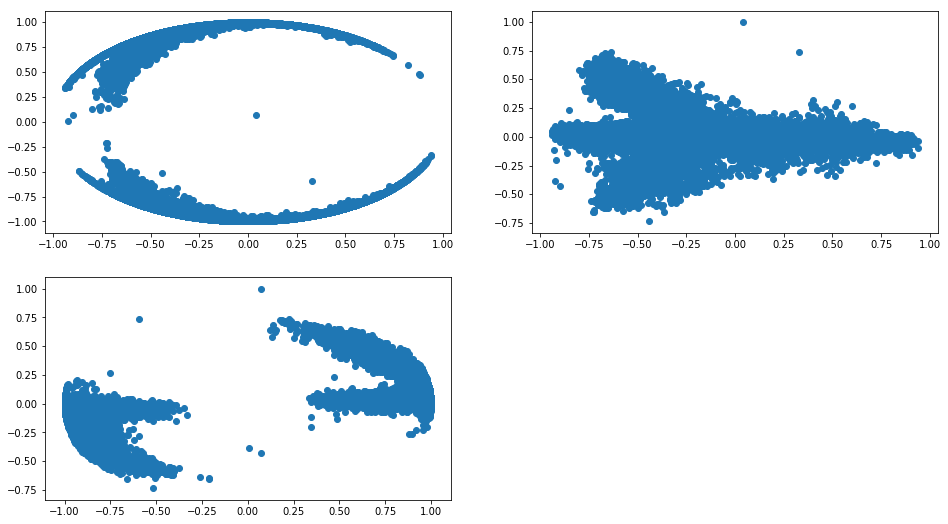

In [24]:
plt.subplot(221)
plt.scatter(R[:,0], R[:,1])
plt.subplot(222)
plt.scatter(R[:,0], R[:,2])
plt.subplot(223)
plt.scatter(R[:,1], R[:,2])

In [25]:
rodrigues(R[0]*Rmag[0], np.array([0,0,1]))

array([ 0.04649029,  0.09608947, -0.99428641])

In [26]:
rot1 = make_quaternion_from_axis_angle(np.array([1,0,0]), np.deg2rad(-102))
rot2 = make_quaternion_from_axis_angle(np.array([0,1,0]), np.deg2rad(-0.9))
rot3 = make_quaternion_from_axis_angle(np.array([0,0,1]), np.deg2rad(-135))
table_to_camera = multiply_quaternions(rot3, multiply_quaternions(rot2,rot1))*np.array([1,-1,-1,-1])

In [30]:
make_quaternion_from_axis_angle(R[0], Rmag[0])

array([0.0154958 , 0.15562107, 0.98636975, 0.05115344])

In [32]:
q = make_quaternion_from_axis_angle(R[0], Rmag[0])
new_q = multiply_quaternions(table_to_camera, q)
new_rot, new_rot_mag = make_axis_angle_from_quaternion(new_q)

In [34]:
rotate_vector(v=np.array([0,0,1]), q=new_q)

array([-0.11642425,  0.97818176,  0.1720635 ])

In [35]:
rotate_vector(v=rotate_vector(v=np.array([0,0,1]), q=new_q), q=table_to_camera*np.array([1,-1,-1,-1]))

array([ 0.04649029,  0.09608947, -0.99428641])

In [44]:
t1 = np.deg2rad(-102)
t2 = np.deg2rad(-0.9)
t3 = np.deg2rad(-135)
rot1 = np.array([[1,0,0],[0,np.cos(t1),-np.sin(t1)],[0,np.sin(t1), np.cos(t1)]])
rot2 = np.array([[np.cos(t2),0,np.sin(t2)],[0,1,0],[-np.sin(t2),0,np.cos(t2)]])
rot3 = np.array([[np.cos(t3), -np.sin(t3), 0],
                 [np.sin(t3), np.cos(t3), 0],
                 [0,0,1]])
rot1@rot2@rot3

array([[-0.70701955,  0.70701955, -0.01570732],
       [ 0.13615173,  0.15787981,  0.97802693],
       [ 0.69396402,  0.68934558, -0.20788604]])

In [43]:
rot3

array([list([-0.7071067811865475, 0.7071067811865476, 0]),
       list([-0.7071067811865476, -0.7071067811865475]), list([0, 0, 1])],
      dtype=object)

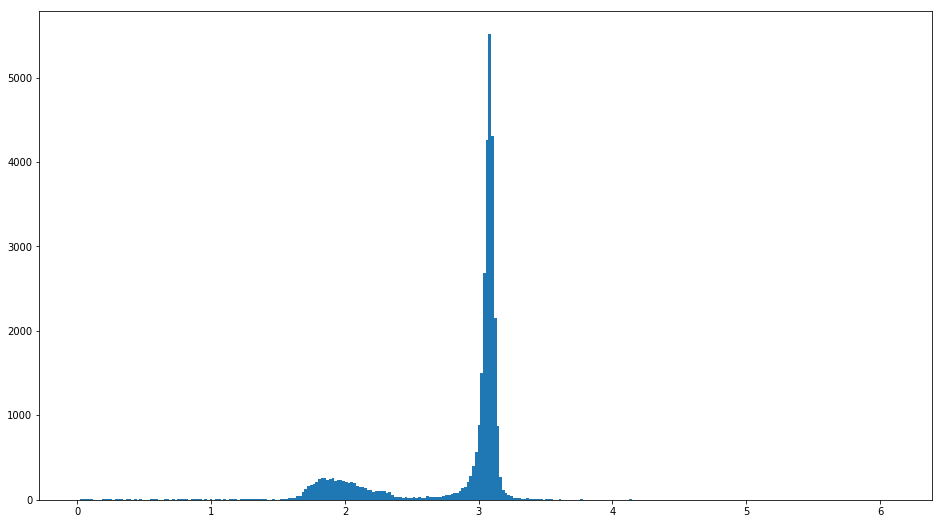

In [19]:
plt.hist(Rmag, bins=300);

In [20]:
(Rmag>np.pi).sum()

1246

In [21]:
(Rmag<np.pi).sum()

30878